In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

def LoadComplexData(file,**genfromtext_args):
    """
    Load complex data in the C++ format in numpy.
    """
    array_as_strings = np.genfromtxt(file,dtype=str,**genfromtext_args)
    complex_parser = np.vectorize(lambda x: complex(*eval(x)))
    return complex_parser(array_as_strings)


In [3]:
w0 = 0.057
period = 2*np.pi/w0
time = np.genfromtxt('../results/time.dat')/period
efield = np.genfromtxt('../results/Afield_k.dat')
# psi2 = np.genfromtxt('../results/init_psi2.dat')
# psi2_end = np.genfromtxt('../results/end_psi2.dat')
acc = LoadComplexData('../results/acc.dat')
mask = LoadComplexData('../results/imask.dat')

/home/rmhsik/Documents/Atoms in magnetic fields/TDSESolver/python/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


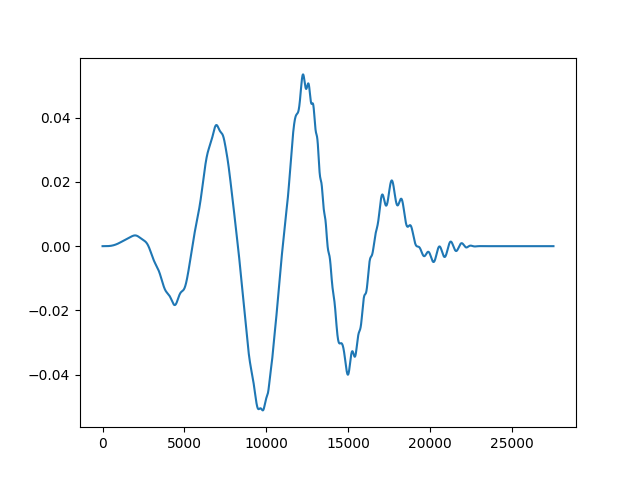

In [5]:
fig = plt.figure()
ax = fig.subplots(1,1)
# ax.plot(psi2)
ax.plot(acc)
# ax2 = ax.twinx()
# ax2.plot(efield)
#ax.set_yscale('log')

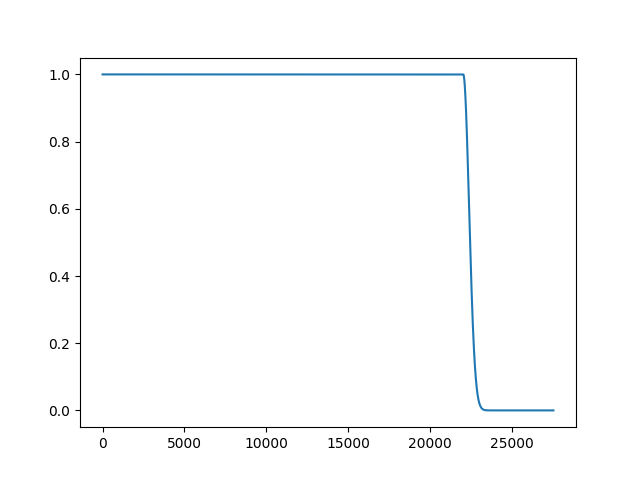

In [43]:
t = np.linspace(0,5.0,1000)
# accmask = np.zeros(1000)
# tmax_ev = 4.0

# for i in range(1000):
#     if t[i]<tmax_ev:
#         accmask[i] = 1.0
#     else:
#         accmask[i] = np.exp(-(t[i]-tmax_ev)**2/0.05)

accmask = LoadComplexData('../results/accmask.dat')

fig = plt.figure()
ax = fig.subplots(1,1)
ax.plot(accmask.real)

In [6]:
period = 2*np.pi/0.057
tmax = 5*period
dt = 0.02
t = np.arange(0,tmax,dt)
accF = np.fft.fft(acc)
accF = np.fft.fftshift(accF)
accF2 = np.abs(accF)**2
accF2 = accF2[int(len(t)/2):]

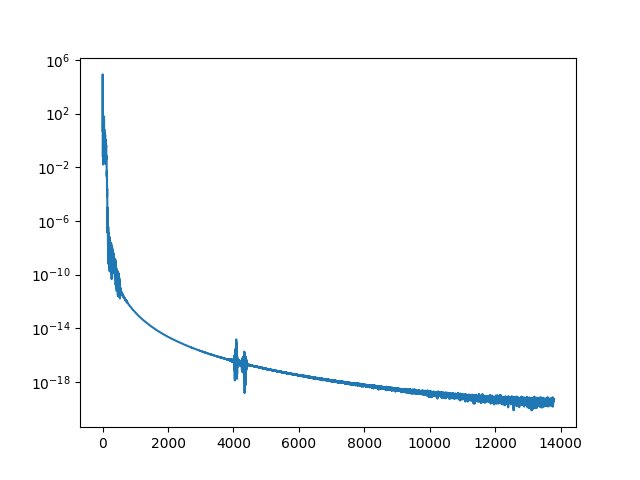

In [7]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.plot(accF2)
ax.set_yscale('log')

In [7]:
x,dx = np.linspace(-240,240,10000, retstep=True)
V = -1/np.sqrt(x*x+2.0)

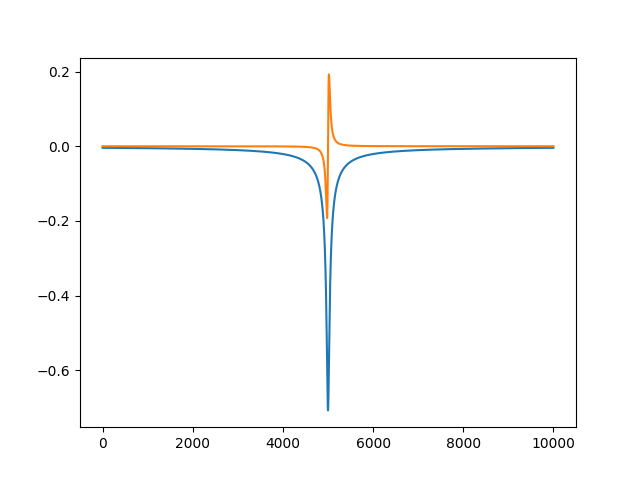

In [8]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.plot(V)
ax.plot(np.gradient(V,dx))

In [9]:
dv = LoadComplexData('../results/dpotential.dat')

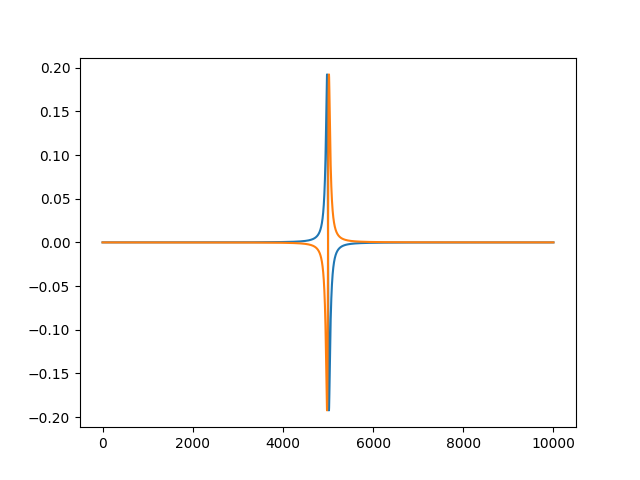

In [13]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.plot(-1*dv.real)
ax.plot(np.gradient(V,dx))